# Clustering

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
len(pd.read_csv('features.csv'))

3417

In [44]:
features = pd.read_csv('features.csv', header=None)
image_names = pd.read_csv('labels.csv', header=None)

In [45]:
to_be_removed = [i for i in range(image_names.shape[0]) if image_names.iloc[i,0]=='desktop.ini']
image_names = image_names.drop(to_be_removed, axis=0)
features = features.drop(to_be_removed, axis=0)
labels = [re.split('_|-', str(image_names.iloc[i,0]))[1] for i in range(image_names.shape[0])]
labels = [l.lower() for l in labels]
labels = np.array(labels)
labels2 = [re.split('_|-', str(image_names.iloc[i,0]))[3] for i in range(image_names.shape[0])]
labels2 = [l.lower().replace('forest', 'jungle').replace('sea5.jpeg', 'sea').replace('see', 'sea').replace('junlge', 'jungle') for l in labels2]
labels2 = np.array(labels2)
features['labels'] = labels

In [73]:
features.head(1)

,0,1,2,3,4,5,6,7,8,9,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,labels
0,0.52297,0.299877,1.854656,-0.12765,0.81365,-0.148206,0.086093,-0.099617,-0.060342,2.059088,...,-0.139349,-0.058845,2.431875,0.062066,-0.245895,0.086882,-0.126205,0.218028,0.169009,fake


In [ ]:
def calculate_purity(true_label, cluster_label):
    temp = pd.DataFrame(data=zip(true_label,cluster_label), columns=['true_label', 'cluster_label'])
    temp = temp.groupby(['cluster_label', 'true_label']).size().rename('cnt').reset_index()
    df = temp.groupby('cluster_label')['cnt'].max().rename('majority_label').reset_index()
    df = df.merge(temp.groupby('cluster_label')['cnt'].sum().rename('total').reset_index(), on='cluster_label', how='left')
    df['purity'] = 100 * df['majority_label'] / df['total']
    return 100 * df['majority_label'].sum() / df['total'].sum()

In [47]:
X = features.drop(columns='labels')

In [13]:
X = features.drop(columns='labels')
data = []
clusters = [2,3,6,9,12,15,18,21,25,30,40,45,50]
for n_clusters in tqdm(clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    cluster_labels = kmeans.predict(X)
    purity = calculate_purity(true_label=features['labels'], cluster_label=cluster_labels)
    silhouette_avg = silhouette_score(X, cluster_labels)
    data.append([n_clusters, kmeans.inertia_, silhouette_avg, purity])
scores_df = pd.DataFrame(data=data, columns=['n_clusters', 'WCSS', 'silhouette_score', 'purity']) # within-cluster sum of squares

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [01:00<00:00,  4.63s/it]


In [ ]:
! renam

In [14]:
scores_df

,n_clusters,WCSS,silhouette_score,purity
0,2,918891.481437,0.295760,99.502633
1,3,756252.590695,0.267586,90.813341
2,6,553594.978993,0.234216,99.590404
3,9,463108.076200,0.205330,99.297835
4,12,411065.310041,0.194995,98.127560
5,15,372390.069206,0.176268,99.356349
6,18,344814.406505,0.174838,99.327092
7,21,325208.861721,0.168529,99.327092
8,25,304071.125924,0.152593,99.005266
9,30,284306.039659,0.150158,98.712697


In [15]:
plotTitleSize = 18
plotAXLableSize = 16
pltDPI = 150
figPath = 'export/'

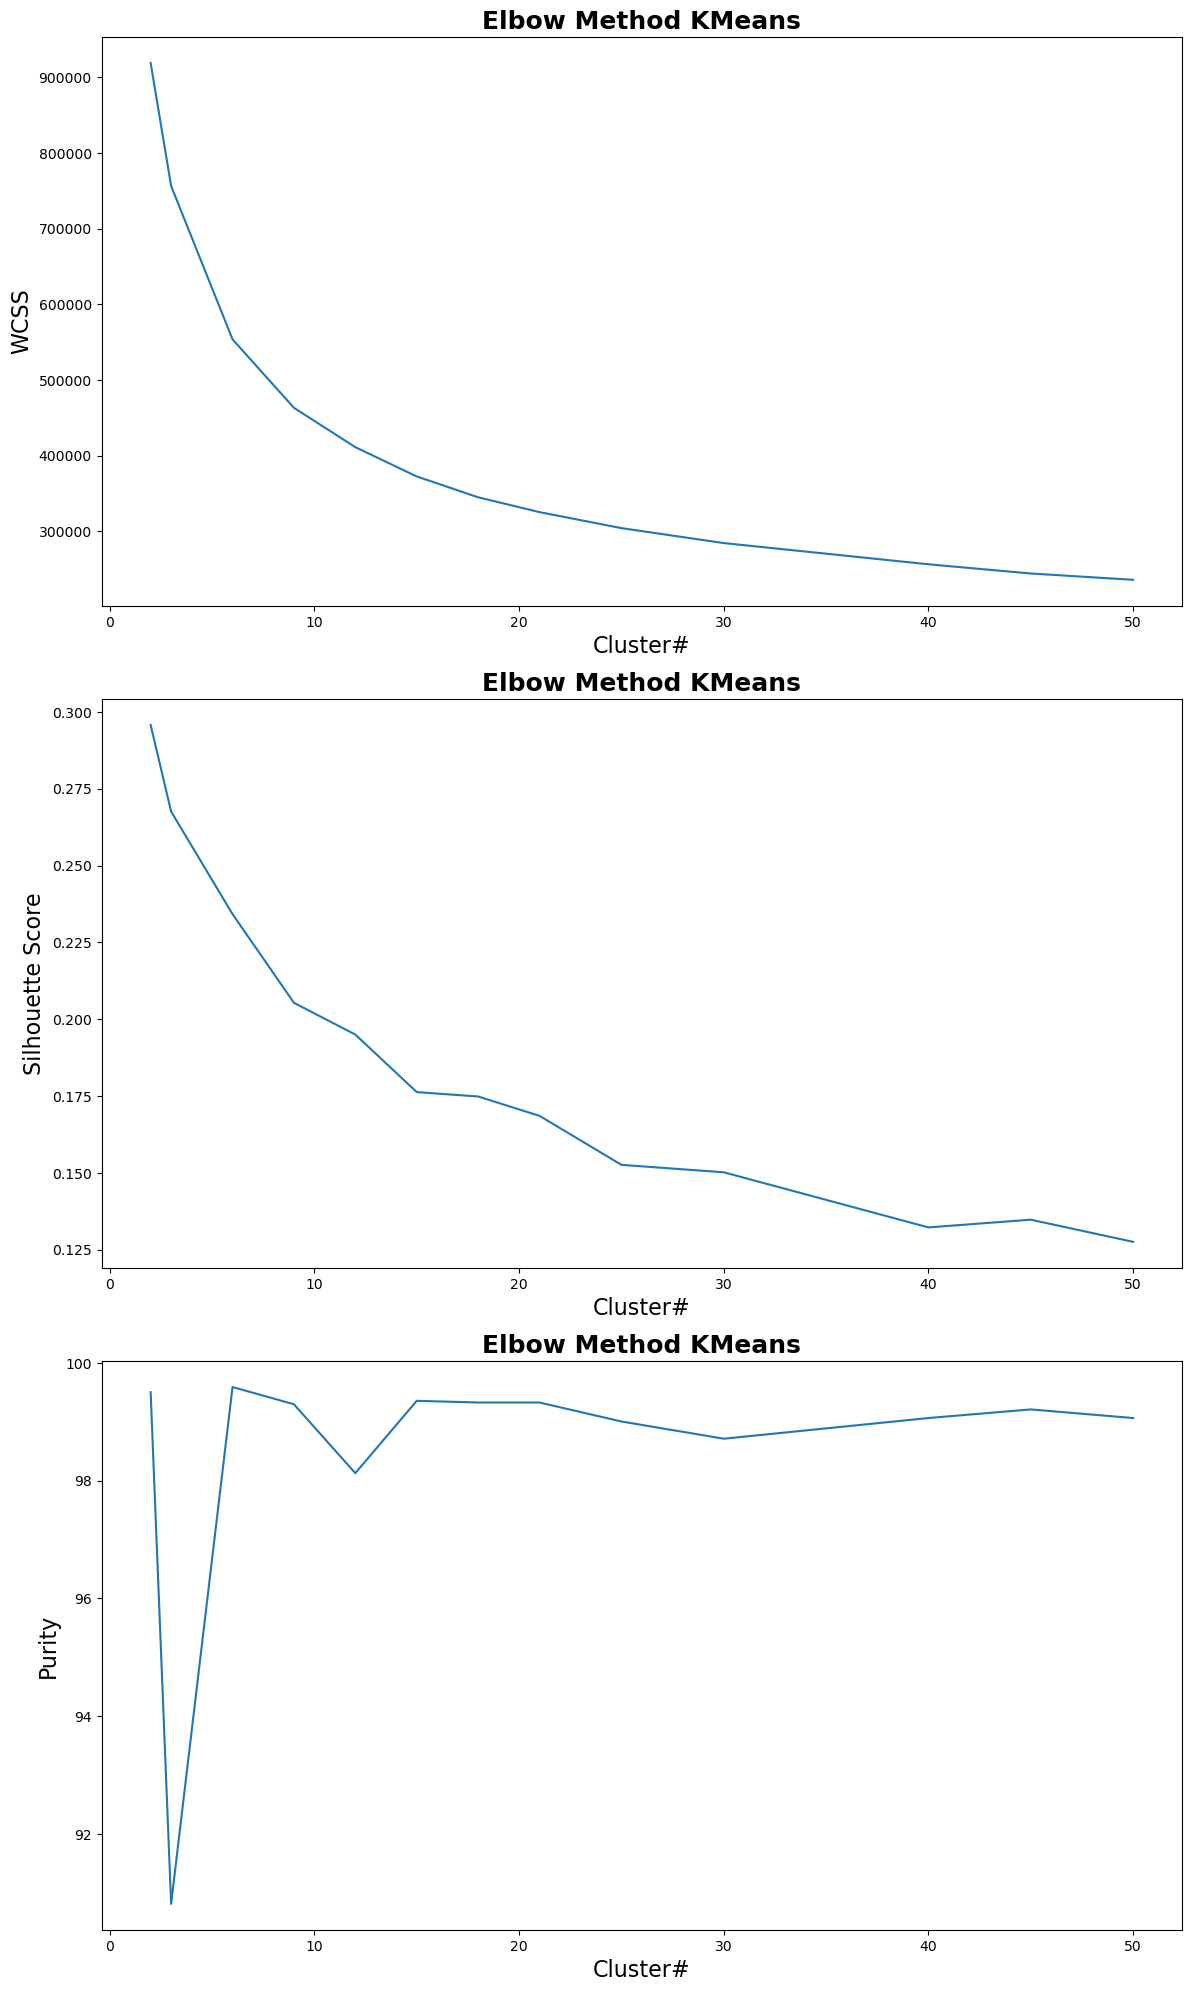

In [16]:
plt.figure(figsize=(12,20))
plt.subplot(3,1,1)
g = sns.lineplot(y='WCSS', x='n_clusters', data=scores_df)
plt.title('Elbow Method KMeans', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('WCSS', fontsize=plotAXLableSize)
plt.xlabel('Cluster#', fontsize=plotAXLableSize)

plt.subplot(3,1,2)
g = sns.lineplot(y='silhouette_score', x='n_clusters', data=scores_df)
plt.title('Elbow Method KMeans', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('Silhouette Score', fontsize=plotAXLableSize)
plt.xlabel('Cluster#', fontsize=plotAXLableSize)


plt.subplot(3,1,3)
g = sns.lineplot(y='purity', x='n_clusters', data=scores_df)
plt.title('Elbow Method KMeans', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('Purity', fontsize=plotAXLableSize)
plt.xlabel('Cluster#', fontsize=plotAXLableSize)


plt.tight_layout(pad=1.0)
plt.savefig(figPath + '1-KMeans.png', dpi=pltDPI)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [04:20<00:00, 21.70s/it]


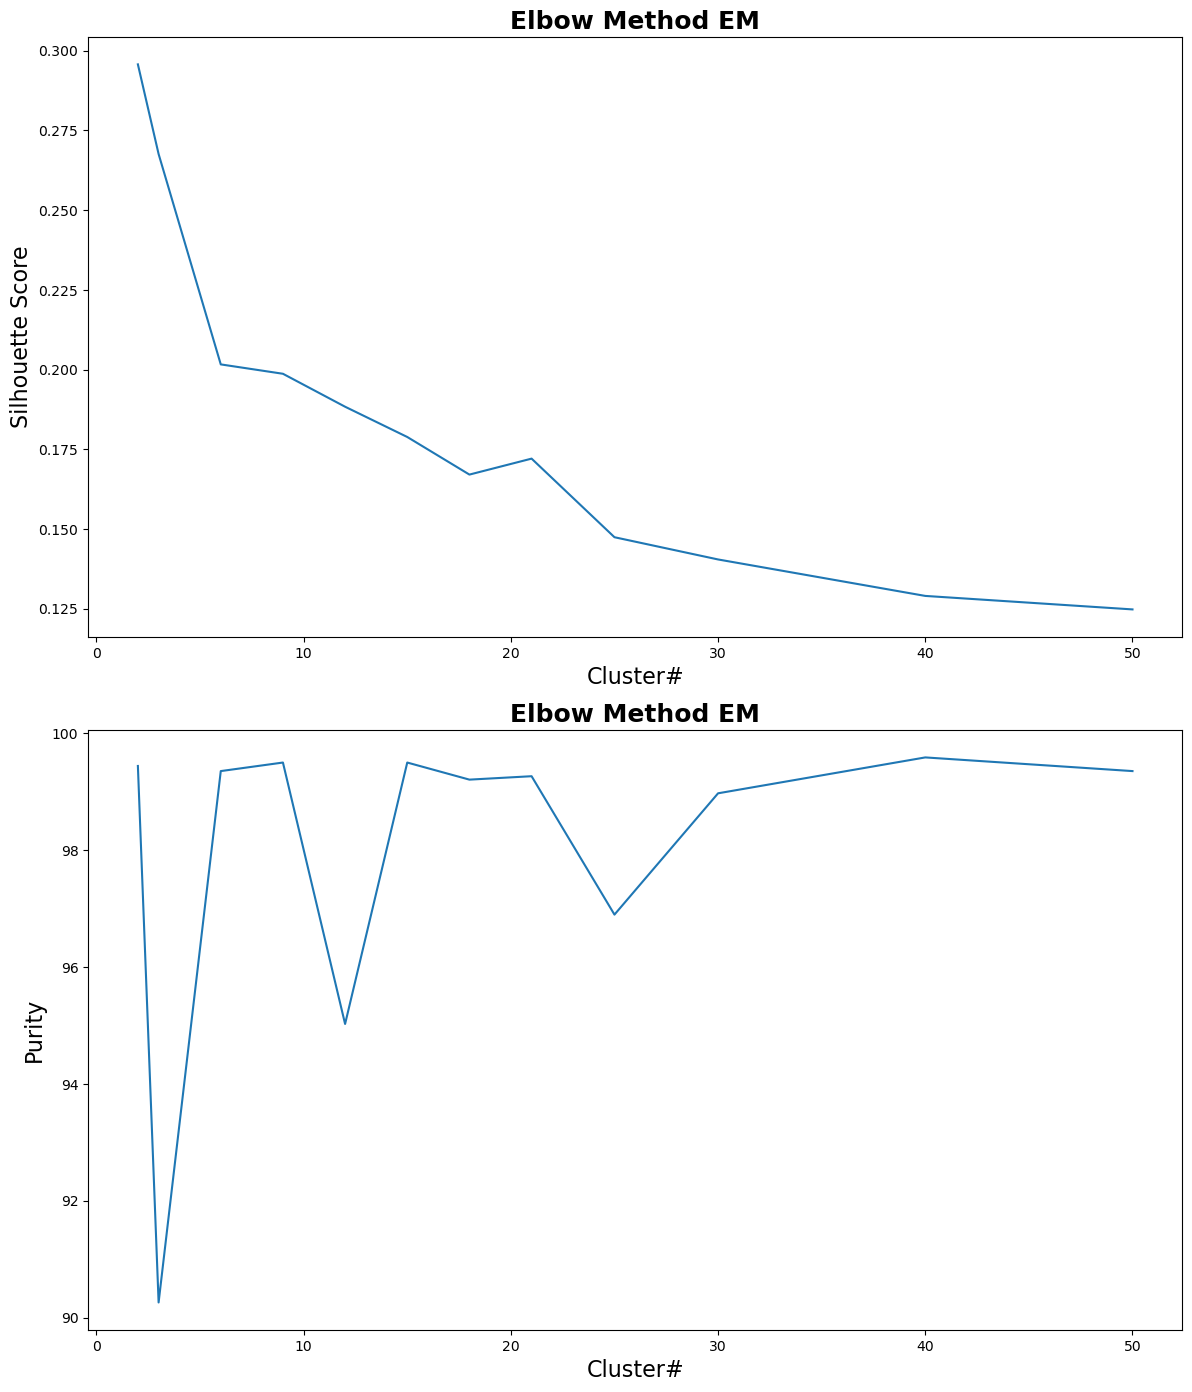

In [21]:
data = []
range_n_clusters = [2,3,6,9,12,15,18,21,25,30,40,50]
X = features.drop(columns='labels')
for n_clusters in tqdm(range_n_clusters):
    gmm = GaussianMixture(n_components=n_clusters)  # Specify the number of clusters
    gmm.fit(X)
    cluster_labels = gmm.predict(X)
    purity = calculate_purity(true_label=features['labels'], cluster_label=cluster_labels)
    silhouette_avg = silhouette_score(X, cluster_labels)
    data.append([n_clusters, silhouette_avg, purity])
    
scores_df = pd.DataFrame(data=data, columns=['n_clusters', 'silhouette_score', 'purity']) # within-cluster sum of squares

plt.figure(figsize=(12,14))
plt.subplot(2,1,1)
g = sns.lineplot(y='silhouette_score', x='n_clusters', data=scores_df)
plt.title('Elbow Method EM', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('Silhouette Score', fontsize=plotAXLableSize)
plt.xlabel('Cluster#', fontsize=plotAXLableSize)

plt.subplot(2,1,2)
g = sns.lineplot(y='purity', x='n_clusters', data=scores_df)
plt.title('Elbow Method EM', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('Purity', fontsize=plotAXLableSize)
plt.xlabel('Cluster#', fontsize=plotAXLableSize)


plt.tight_layout(pad=1.0)
plt.savefig(figPath + '2-EM.png', dpi=pltDPI)

In [23]:
scores_df

,n_clusters,silhouette_score,purity
0,2,0.295718,99.444119
1,3,0.267592,90.257461
2,6,0.201606,99.356349
3,9,0.198666,99.502633
4,12,0.188328,95.026331
5,15,0.178835,99.502633
6,18,0.167042,99.210064
7,21,0.172049,99.268578
8,25,0.147396,96.898771
9,30,0.140420,98.976009


In [42]:
# neighbors = NearestNeighbors(n_neighbors=150)
# neighbors_fit = neighbors.fit(X)
# distances, indices = neighbors_fit.kneighbors(X)

In [ ]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.axhline(y=9, color='r')
plt.plot(distances)

In [48]:
eps_array = [2, 4, 6, 8, 10, 12, 15, 20]
min_sampel_array = [5, 10, 15, 30, 40, 50, 70, 100, 150, 300]
data = []
for eps in tqdm(eps_array):
    for min_sampel in min_sampel_array:
        clustering = DBSCAN(eps=eps, min_samples=min_sampel).fit(X)
        n_clusters = len(np.unique(clustering.labels_))
        if n_clusters <= 1:
            continue
        cluster_labels = clustering.labels_
        silhouette_avg = silhouette_score(X, cluster_labels)
        purity = calculate_purity(true_label=features['labels'], cluster_label=clustering.labels_)
        data.append([eps, min_sampel, n_clusters, silhouette_avg, purity])
        
scores_df = pd.DataFrame(data=data, columns=['eps', 'min_sampel', 'n_clusters', 'silhouette_avg', 'purity'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:46<00:00,  5.82s/it]


In [55]:
scores_df.to_csv('DBScan_res.csv', index=False)

In [57]:
scores_df.head(50)

,eps,min_sampel,n_clusters,silhouette_avg,purity
0,2,5,7,-0.315483,50.643651
1,4,5,9,-0.379122,59.566998
2,4,10,2,-0.066170,57.489760
3,4,15,2,-0.085760,55.354008
4,4,30,3,-0.217441,53.920421
5,4,40,3,-0.230043,52.837917
6,4,50,3,-0.236035,52.340550
7,6,5,12,-0.169712,62.697484
8,6,10,4,-0.083751,62.931539
9,6,15,2,0.089930,62.960796


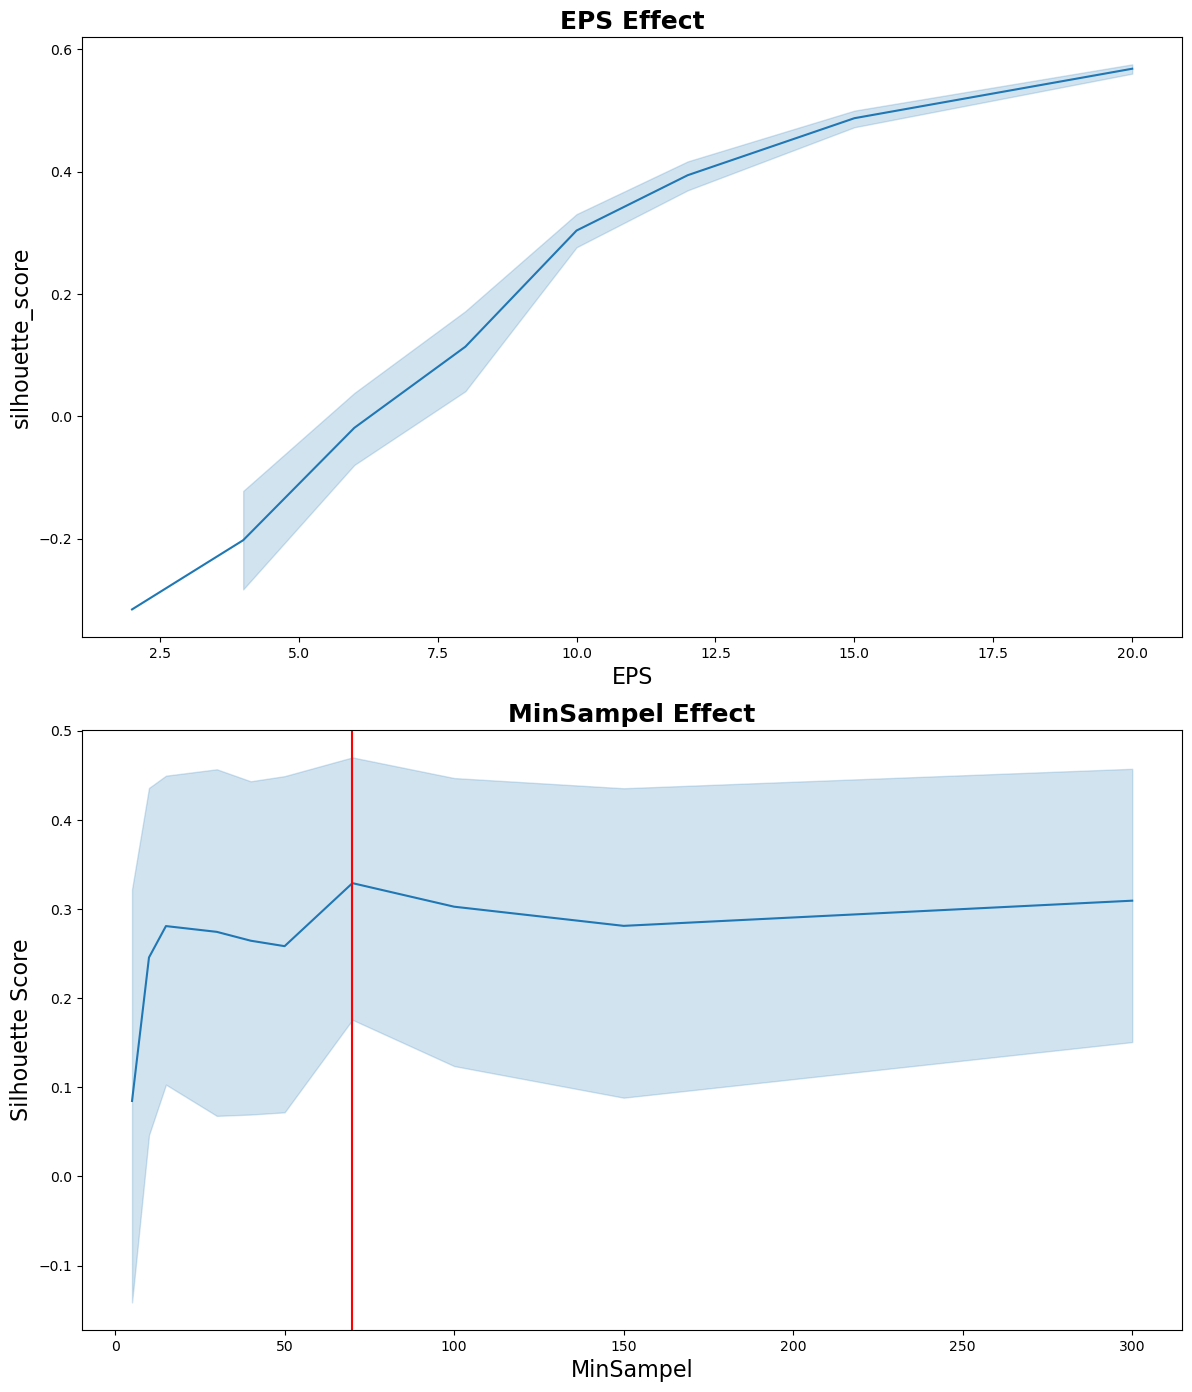

In [50]:
plt.figure(figsize=(12,14))
plt.subplot(2,1,1)
g = sns.lineplot(y='silhouette_avg', x='eps', data=scores_df)
plt.title('EPS Effect', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('silhouette_score', fontsize=plotAXLableSize)
plt.xlabel('EPS', fontsize=plotAXLableSize)

plt.subplot(2,1,2)
g = sns.lineplot(y='silhouette_avg', x='min_sampel', data=scores_df)
plt.title('MinSampel Effect', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('Silhouette Score', fontsize=plotAXLableSize)
plt.xlabel('MinSampel', fontsize=plotAXLableSize)
plt.axvline(x=70, color='r')

plt.tight_layout(pad=1.0)
plt.savefig(figPath + '3-DBScan.png', dpi=pltDPI)

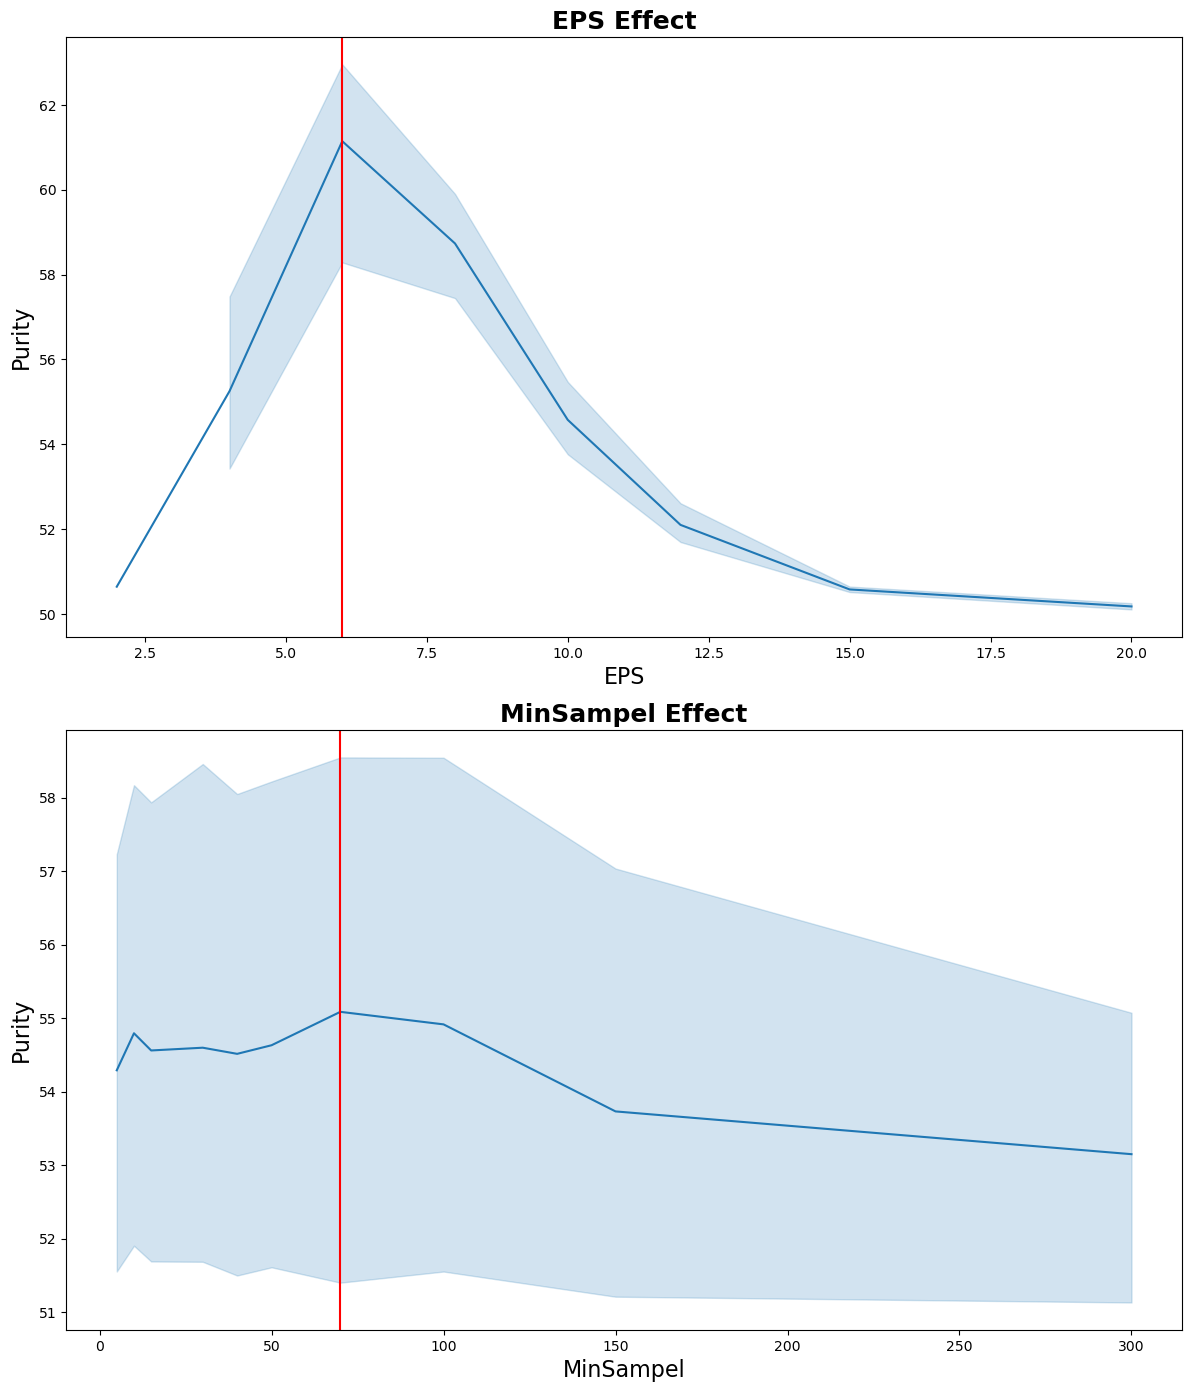

In [51]:
plt.figure(figsize=(12,14))
plt.subplot(2,1,1)
g = sns.lineplot(y='purity', x='eps', data=scores_df)
plt.title('EPS Effect', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('Purity', fontsize=plotAXLableSize)
plt.xlabel('EPS', fontsize=plotAXLableSize)
plt.axvline(x=6, color='r')

plt.subplot(2,1,2)
g = sns.lineplot(y='purity', x='min_sampel', data=scores_df)
plt.title('MinSampel Effect', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('Purity', fontsize=plotAXLableSize)
plt.xlabel('MinSampel', fontsize=plotAXLableSize)
plt.axvline(x=70, color='r')

plt.tight_layout(pad=1.0)
plt.savefig(figPath + '4-DBScan.png', dpi=pltDPI)

# Extracted Freature

## HOG

In [52]:
featur_df = pd.read_csv('hog_feature.csv')

In [53]:
X = featur_df[featur_df.columns[:-2]]
y = featur_df[featur_df.columns[-2]]

In [4]:
def calculate_purity(true_label, cluster_label):
    temp = pd.DataFrame(data=zip(true_label,cluster_label), columns=['true_label', 'cluster_label'])
    temp = temp.groupby(['cluster_label', 'true_label']).size().rename('cnt').reset_index()
    df = temp.groupby('cluster_label')['cnt'].max().rename('majority_label').reset_index()
    df = df.merge(temp.groupby('cluster_label')['cnt'].sum().rename('total').reset_index(), on='cluster_label', how='left')
    df['purity'] = 100 * df['majority_label'] / df['total']
    return 100 * df['majority_label'].sum() / df['total'].sum()

In [5]:
data = []
clusters = [2,3,6,9,12,15,18,21,25,30,40,45,50]
for n_clusters in tqdm(clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    cluster_labels = kmeans.predict(X)
    purity = calculate_purity(true_label=y, cluster_label=cluster_labels)
    silhouette_avg = silhouette_score(X, cluster_labels)
    data.append([n_clusters, kmeans.inertia_, silhouette_avg, purity])
scores_df = pd.DataFrame(data=data, columns=['n_clusters', 'WCSS', 'silhouette_score', 'purity']) # within-cluster sum of squares

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:45<00:00,  3.47s/it]


In [6]:
scores_df

,n_clusters,WCSS,silhouette_score,purity
0,2,78674.023382,0.094738,53.292362
1,3,76408.431550,0.052316,55.165350
2,6,73251.005932,0.021191,54.843430
3,9,71724.365574,0.013840,55.370208
4,12,70657.968475,0.014958,57.184665
5,15,69999.416583,0.009764,56.101844
6,18,69391.237082,0.007140,56.014047
7,21,68893.528571,-0.007540,56.979807
8,25,68430.672671,-0.005296,56.833480
9,30,67750.404007,-0.014470,57.974832


In [7]:
plotTitleSize = 18
plotAXLableSize = 16
pltDPI = 150
figPath = 'export/'

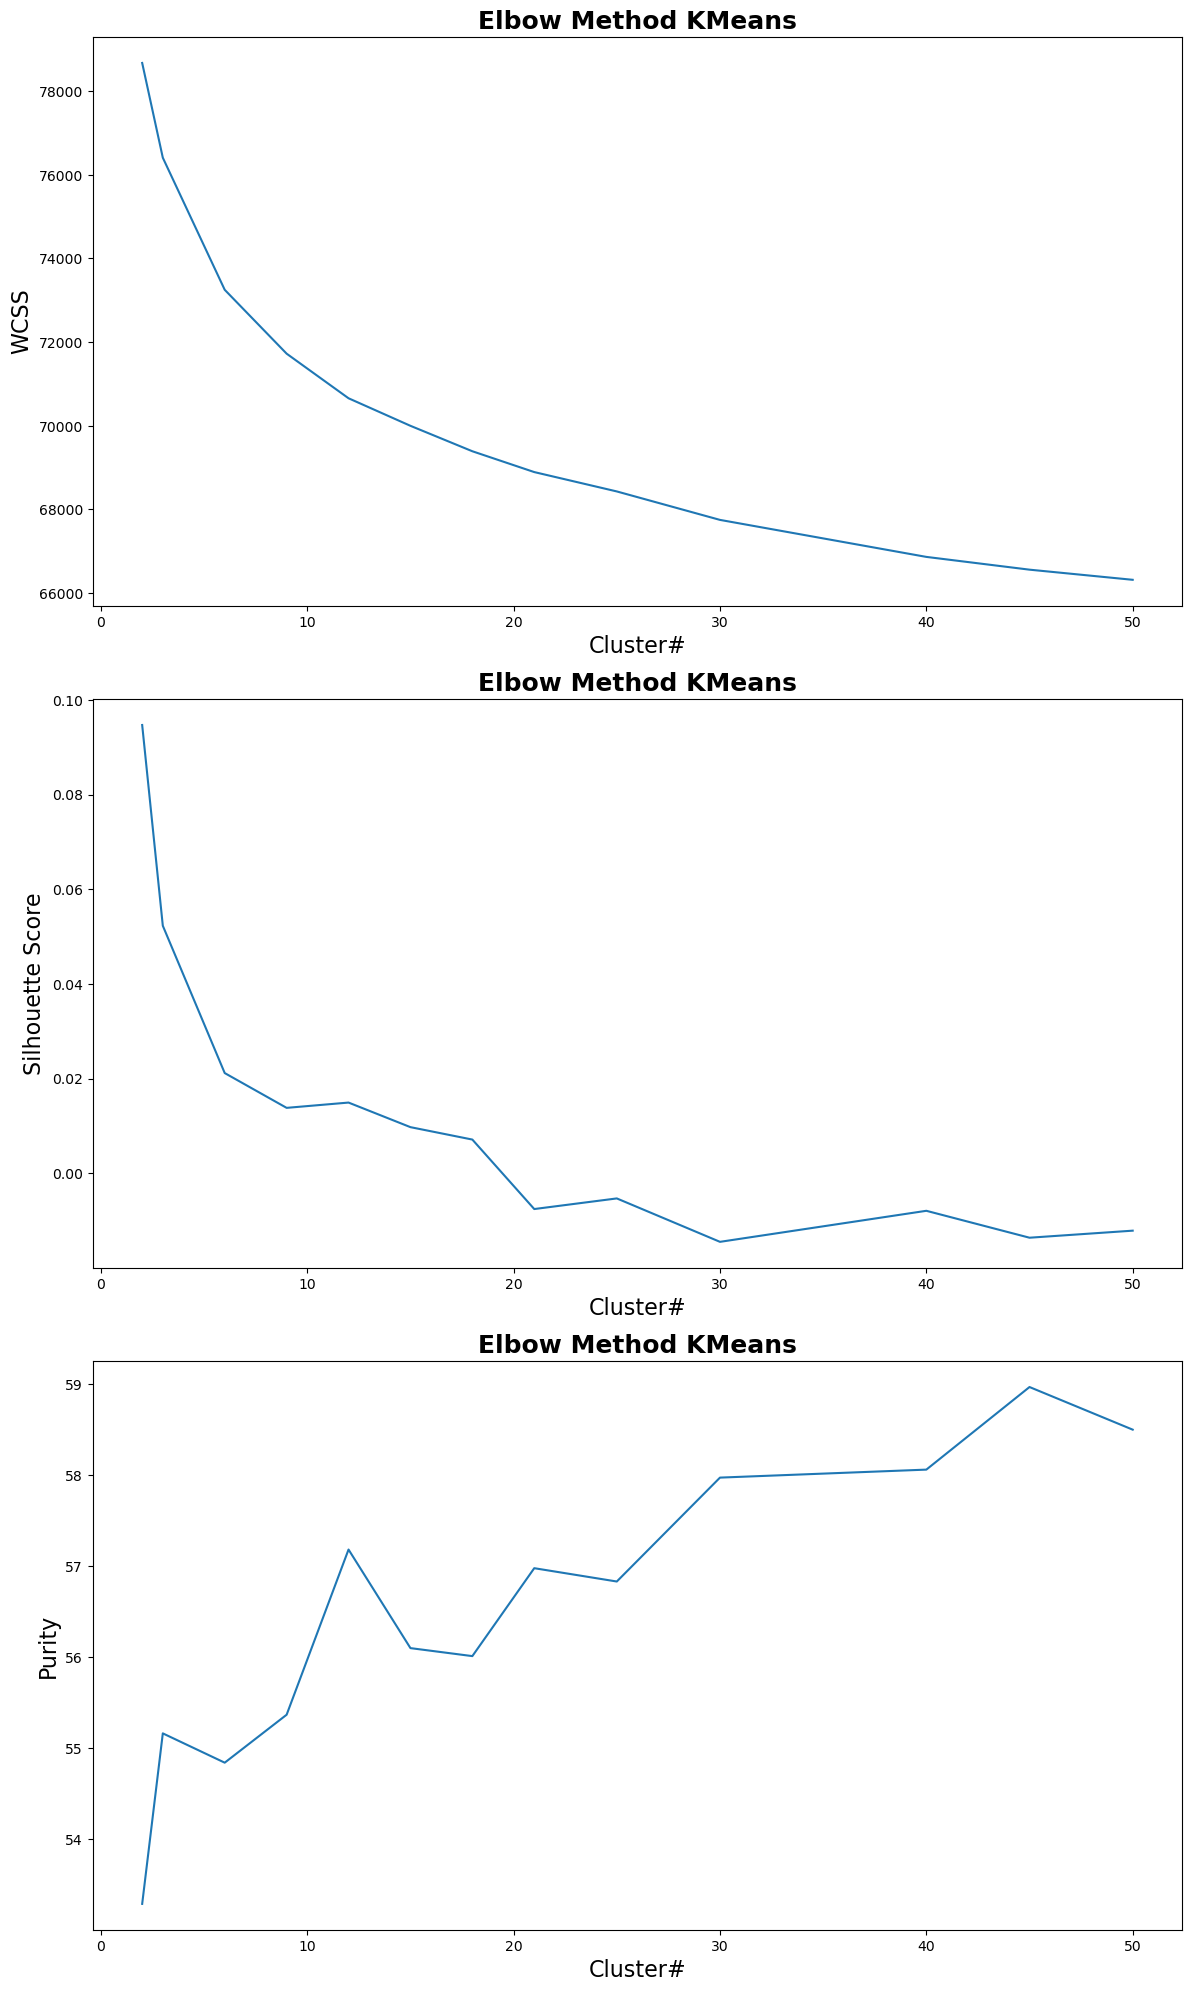

In [8]:
plt.figure(figsize=(12,20))
plt.subplot(3,1,1)
g = sns.lineplot(y='WCSS', x='n_clusters', data=scores_df)
plt.title('Elbow Method KMeans', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('WCSS', fontsize=plotAXLableSize)
plt.xlabel('Cluster#', fontsize=plotAXLableSize)

plt.subplot(3,1,2)
g = sns.lineplot(y='silhouette_score', x='n_clusters', data=scores_df)
plt.title('Elbow Method KMeans', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('Silhouette Score', fontsize=plotAXLableSize)
plt.xlabel('Cluster#', fontsize=plotAXLableSize)


plt.subplot(3,1,3)
g = sns.lineplot(y='purity', x='n_clusters', data=scores_df)
plt.title('Elbow Method KMeans', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('Purity', fontsize=plotAXLableSize)
plt.xlabel('Cluster#', fontsize=plotAXLableSize)


plt.tight_layout(pad=1.0)
plt.savefig(figPath + '1-KMeans_hog_feature.png', dpi=pltDPI)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:51<00:00,  9.28s/it]


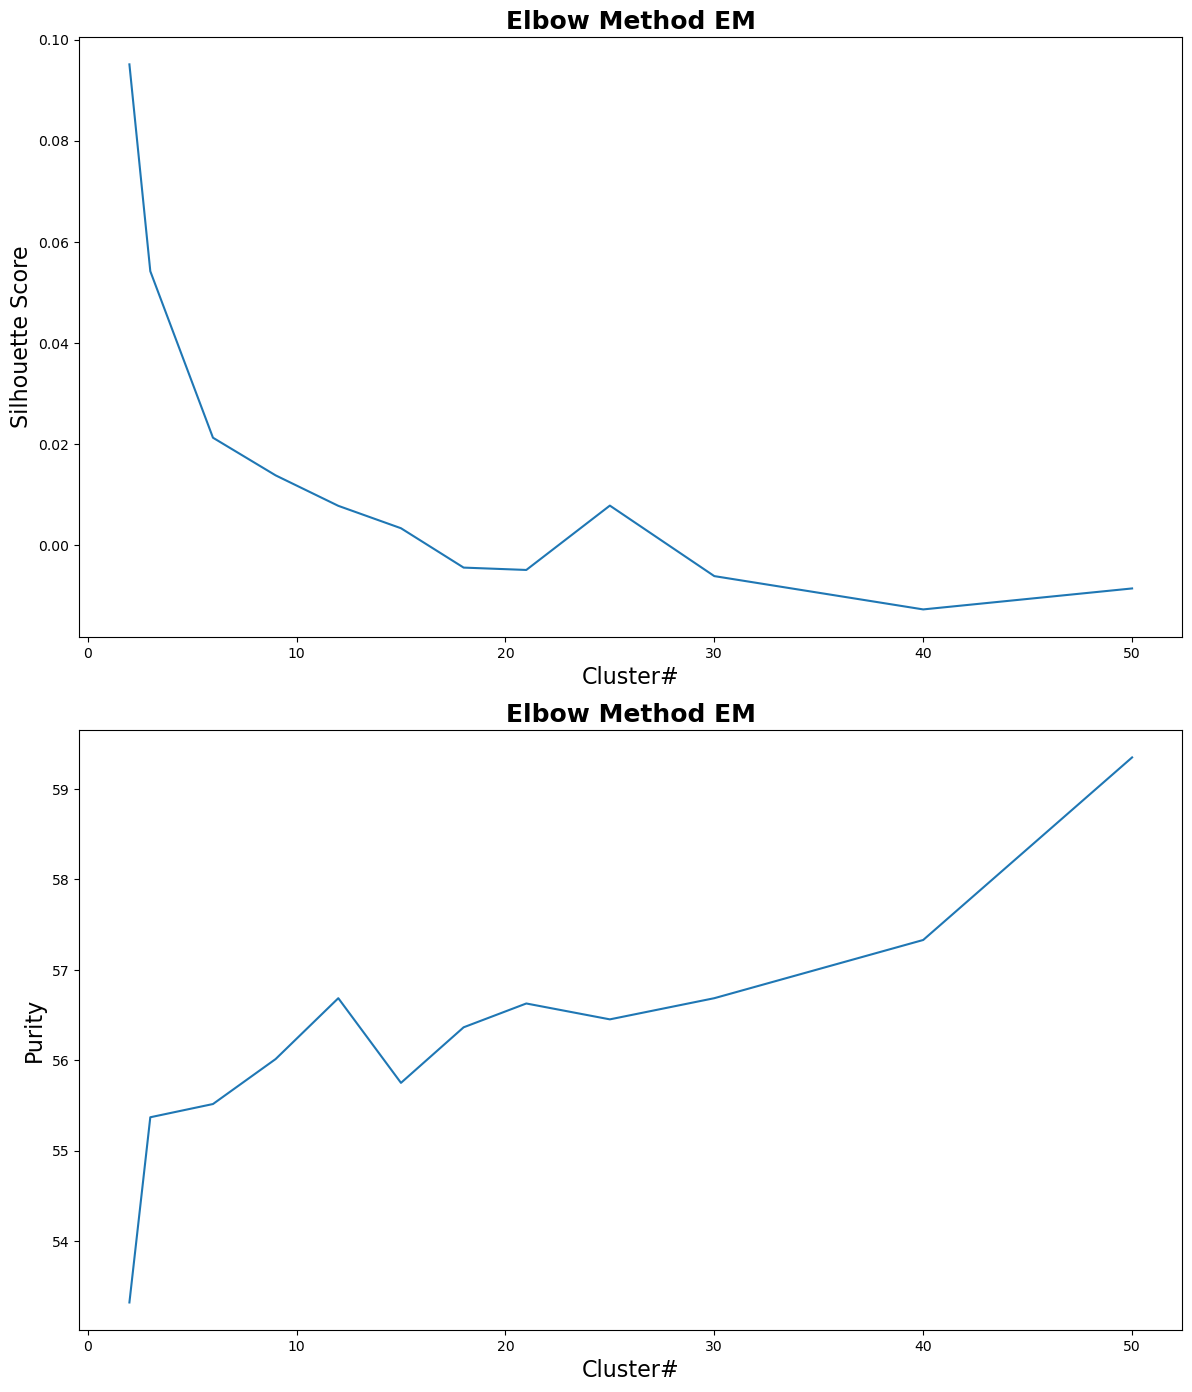

In [9]:
data = []
range_n_clusters = [2,3,6,9,12,15,18,21,25,30,40,50]
for n_clusters in tqdm(range_n_clusters):
    gmm = GaussianMixture(n_components=n_clusters)  # Specify the number of clusters
    gmm.fit(X)
    cluster_labels = gmm.predict(X)
    purity = calculate_purity(true_label=y, cluster_label=cluster_labels)
    silhouette_avg = silhouette_score(X, cluster_labels)
    data.append([n_clusters, silhouette_avg, purity])
    
scores_df = pd.DataFrame(data=data, columns=['n_clusters', 'silhouette_score', 'purity']) # within-cluster sum of squares

plt.figure(figsize=(12,14))
plt.subplot(2,1,1)
g = sns.lineplot(y='silhouette_score', x='n_clusters', data=scores_df)
plt.title('Elbow Method EM', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('Silhouette Score', fontsize=plotAXLableSize)
plt.xlabel('Cluster#', fontsize=plotAXLableSize)

plt.subplot(2,1,2)
g = sns.lineplot(y='purity', x='n_clusters', data=scores_df)
plt.title('Elbow Method EM', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('Purity', fontsize=plotAXLableSize)
plt.xlabel('Cluster#', fontsize=plotAXLableSize)


plt.tight_layout(pad=1.0)
plt.savefig(figPath + '2-EM_hog_feature.png', dpi=pltDPI)

In [10]:
scores_df

,n_clusters,silhouette_score,purity
0,2,0.095100,53.321627
1,3,0.054188,55.370208
2,6,0.021256,55.516535
3,9,0.013810,56.014047
4,12,0.007785,56.687152
5,15,0.003354,55.750658
6,18,-0.004432,56.365233
7,21,-0.004897,56.628622
8,25,0.007831,56.453029
9,30,-0.006116,56.687152


In [54]:
eps_array = [2, 4, 6, 8, 10, 12, 15, 20]
min_sampel_array = [5, 10, 15, 30, 40, 50, 70, 100, 150, 300]
data = []
for eps in tqdm(eps_array):
    for min_sampel in min_sampel_array:
        clustering = DBSCAN(eps=eps, min_samples=min_sampel).fit(X)
        n_clusters = len(np.unique(clustering.labels_))
        if n_clusters <= 1:
            continue
        cluster_labels = clustering.labels_
        silhouette_avg = silhouette_score(X, cluster_labels)
        purity = calculate_purity(true_label=y, cluster_label=clustering.labels_)
        data.append([eps, min_sampel, n_clusters, silhouette_avg, purity])
        
scores_df = pd.DataFrame(data=data, columns=['eps', 'min_sampel', 'n_clusters', 'silhouette_avg', 'purity'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:28<00:00,  3.55s/it]


In [55]:
scores_df

,eps,min_sampel,n_clusters,silhouette_avg,purity
0,2,5,4,-0.197977,50.512145
1,4,5,6,-0.143285,51.653497
2,4,10,2,-0.118794,51.038923
3,4,15,2,-0.118794,51.038923
4,4,30,2,-0.119845,50.921861
5,4,40,2,-0.120732,50.863330
6,4,50,2,-0.121526,50.775534
7,4,70,2,-0.121526,50.775534
8,4,100,2,-0.126198,50.834065
9,4,150,2,-0.128629,50.804800


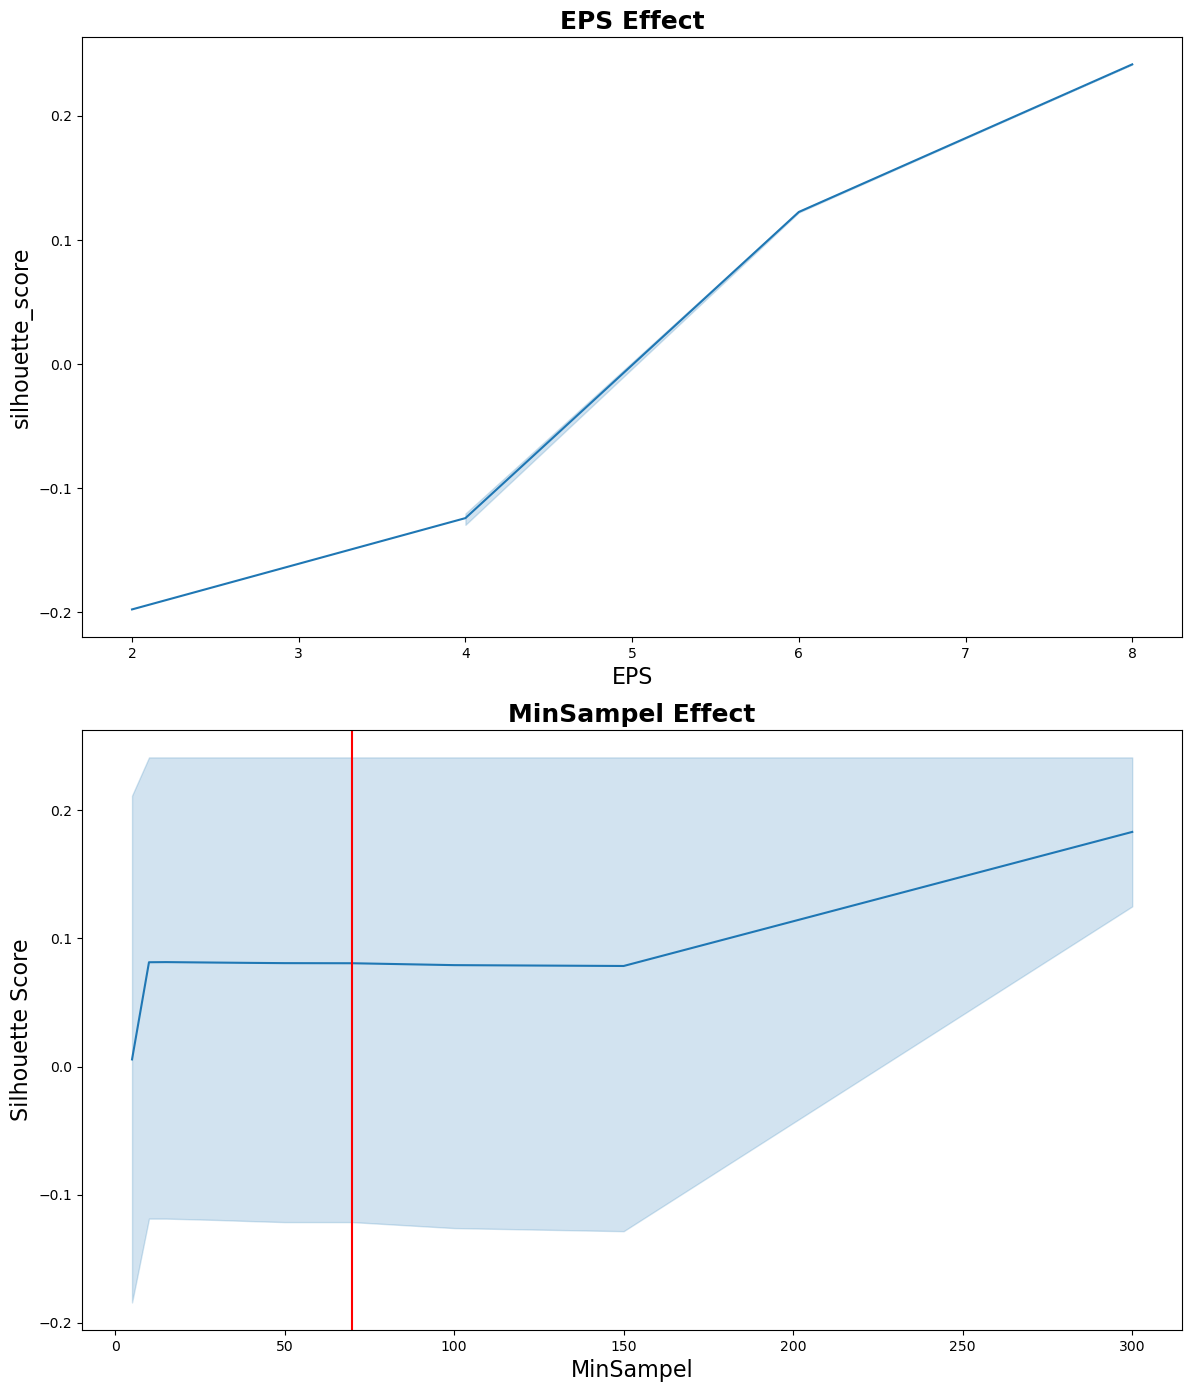

In [59]:
plt.figure(figsize=(12,14))
plt.subplot(2,1,1)
g = sns.lineplot(y='silhouette_avg', x='eps', data=scores_df)
plt.title('EPS Effect', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('silhouette_score', fontsize=plotAXLableSize)
plt.xlabel('EPS', fontsize=plotAXLableSize)

plt.subplot(2,1,2)
g = sns.lineplot(y='silhouette_avg', x='min_sampel', data=scores_df)
plt.title('MinSampel Effect', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('Silhouette Score', fontsize=plotAXLableSize)
plt.xlabel('MinSampel', fontsize=plotAXLableSize)
plt.axvline(x=70, color='r')

plt.tight_layout(pad=1.0)
plt.savefig(figPath + '3-DBScan_hog_feature.png', dpi=pltDPI)

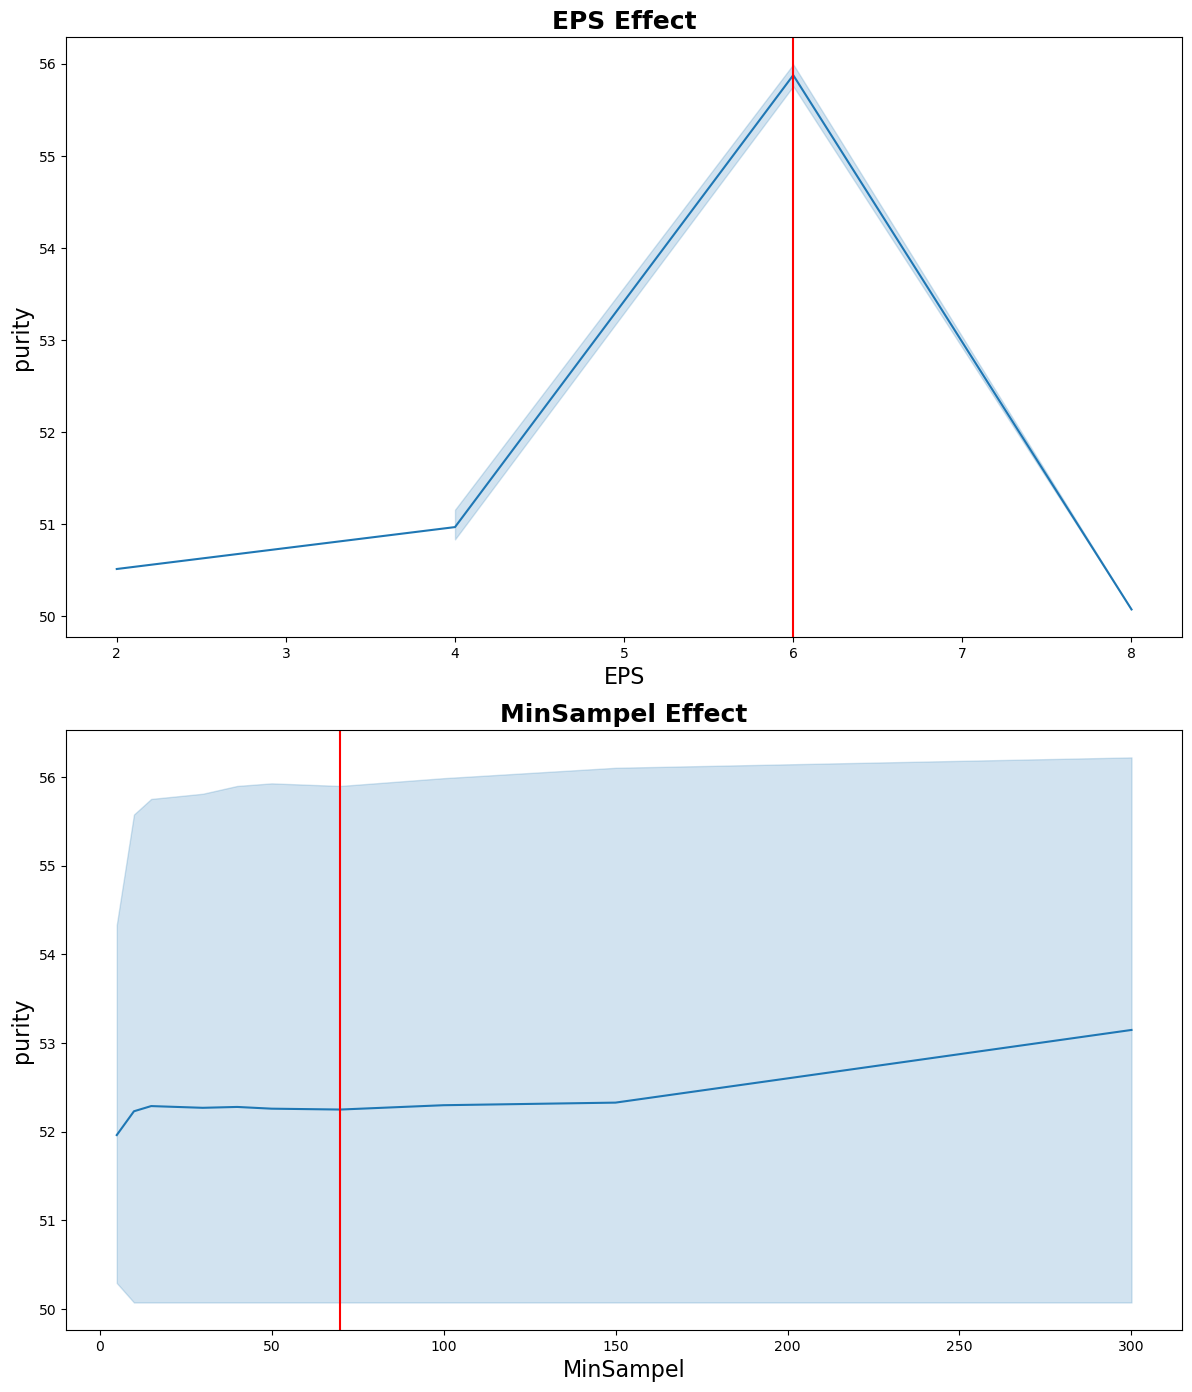

In [58]:
plt.figure(figsize=(12,14))
plt.subplot(2,1,1)
g = sns.lineplot(y='purity', x='eps', data=scores_df)
plt.title('EPS Effect', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('purity', fontsize=plotAXLableSize)
plt.xlabel('EPS', fontsize=plotAXLableSize)
plt.axvline(x=6, color='r')

plt.subplot(2,1,2)
g = sns.lineplot(y='purity', x='min_sampel', data=scores_df)
plt.title('MinSampel Effect', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('purity', fontsize=plotAXLableSize)
plt.xlabel('MinSampel', fontsize=plotAXLableSize)
plt.axvline(x=70, color='r')

plt.tight_layout(pad=1.0)
plt.savefig(figPath + '4-DBScan_hog_feature.png', dpi=pltDPI)

## LBP

In [ ]:
featur_df = pd.read_csv('LBP_feature.csv')

In [60]:
X = featur_df[featur_df.columns[:-2]]
y = featur_df[featur_df.columns[-2]]

In [17]:
def calculate_purity(true_label, cluster_label):
    temp = pd.DataFrame(data=zip(true_label,cluster_label), columns=['true_label', 'cluster_label'])
    temp = temp.groupby(['cluster_label', 'true_label']).size().rename('cnt').reset_index()
    df = temp.groupby('cluster_label')['cnt'].max().rename('majority_label').reset_index()
    df = df.merge(temp.groupby('cluster_label')['cnt'].sum().rename('total').reset_index(), on='cluster_label', how='left')
    df['purity'] = 100 * df['majority_label'] / df['total']
    return 100 * df['majority_label'].sum() / df['total'].sum()

In [18]:
data = []
clusters = [2,3,6,9,12,15,18,21,25,30,40,45,50]
for n_clusters in tqdm(clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    cluster_labels = kmeans.predict(X)
    purity = calculate_purity(true_label=y, cluster_label=cluster_labels)
    silhouette_avg = silhouette_score(X, cluster_labels)
    data.append([n_clusters, kmeans.inertia_, silhouette_avg, purity])
scores_df = pd.DataFrame(data=data, columns=['n_clusters', 'WCSS', 'silhouette_score', 'purity']) # within-cluster sum of squares

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [02:36<00:00, 12.03s/it]


In [19]:
scores_df

,n_clusters,WCSS,silhouette_score,purity
0,2,9.996486e+08,0.019721,50.687738
1,3,9.933350e+08,-0.014559,52.121744
2,6,9.874354e+08,-0.020730,54.287387
3,9,9.856533e+08,-0.025712,54.784899
4,12,9.821748e+08,-0.033667,55.136084
5,15,9.816574e+08,-0.030841,53.643547
6,18,9.761582e+08,-0.030158,54.170325
7,21,9.766634e+08,-0.029159,54.111794
8,25,9.743650e+08,-0.039322,54.989757
9,30,9.700073e+08,-0.035544,54.141059


In [20]:
plotTitleSize = 18
plotAXLableSize = 16
pltDPI = 150
figPath = 'export/'

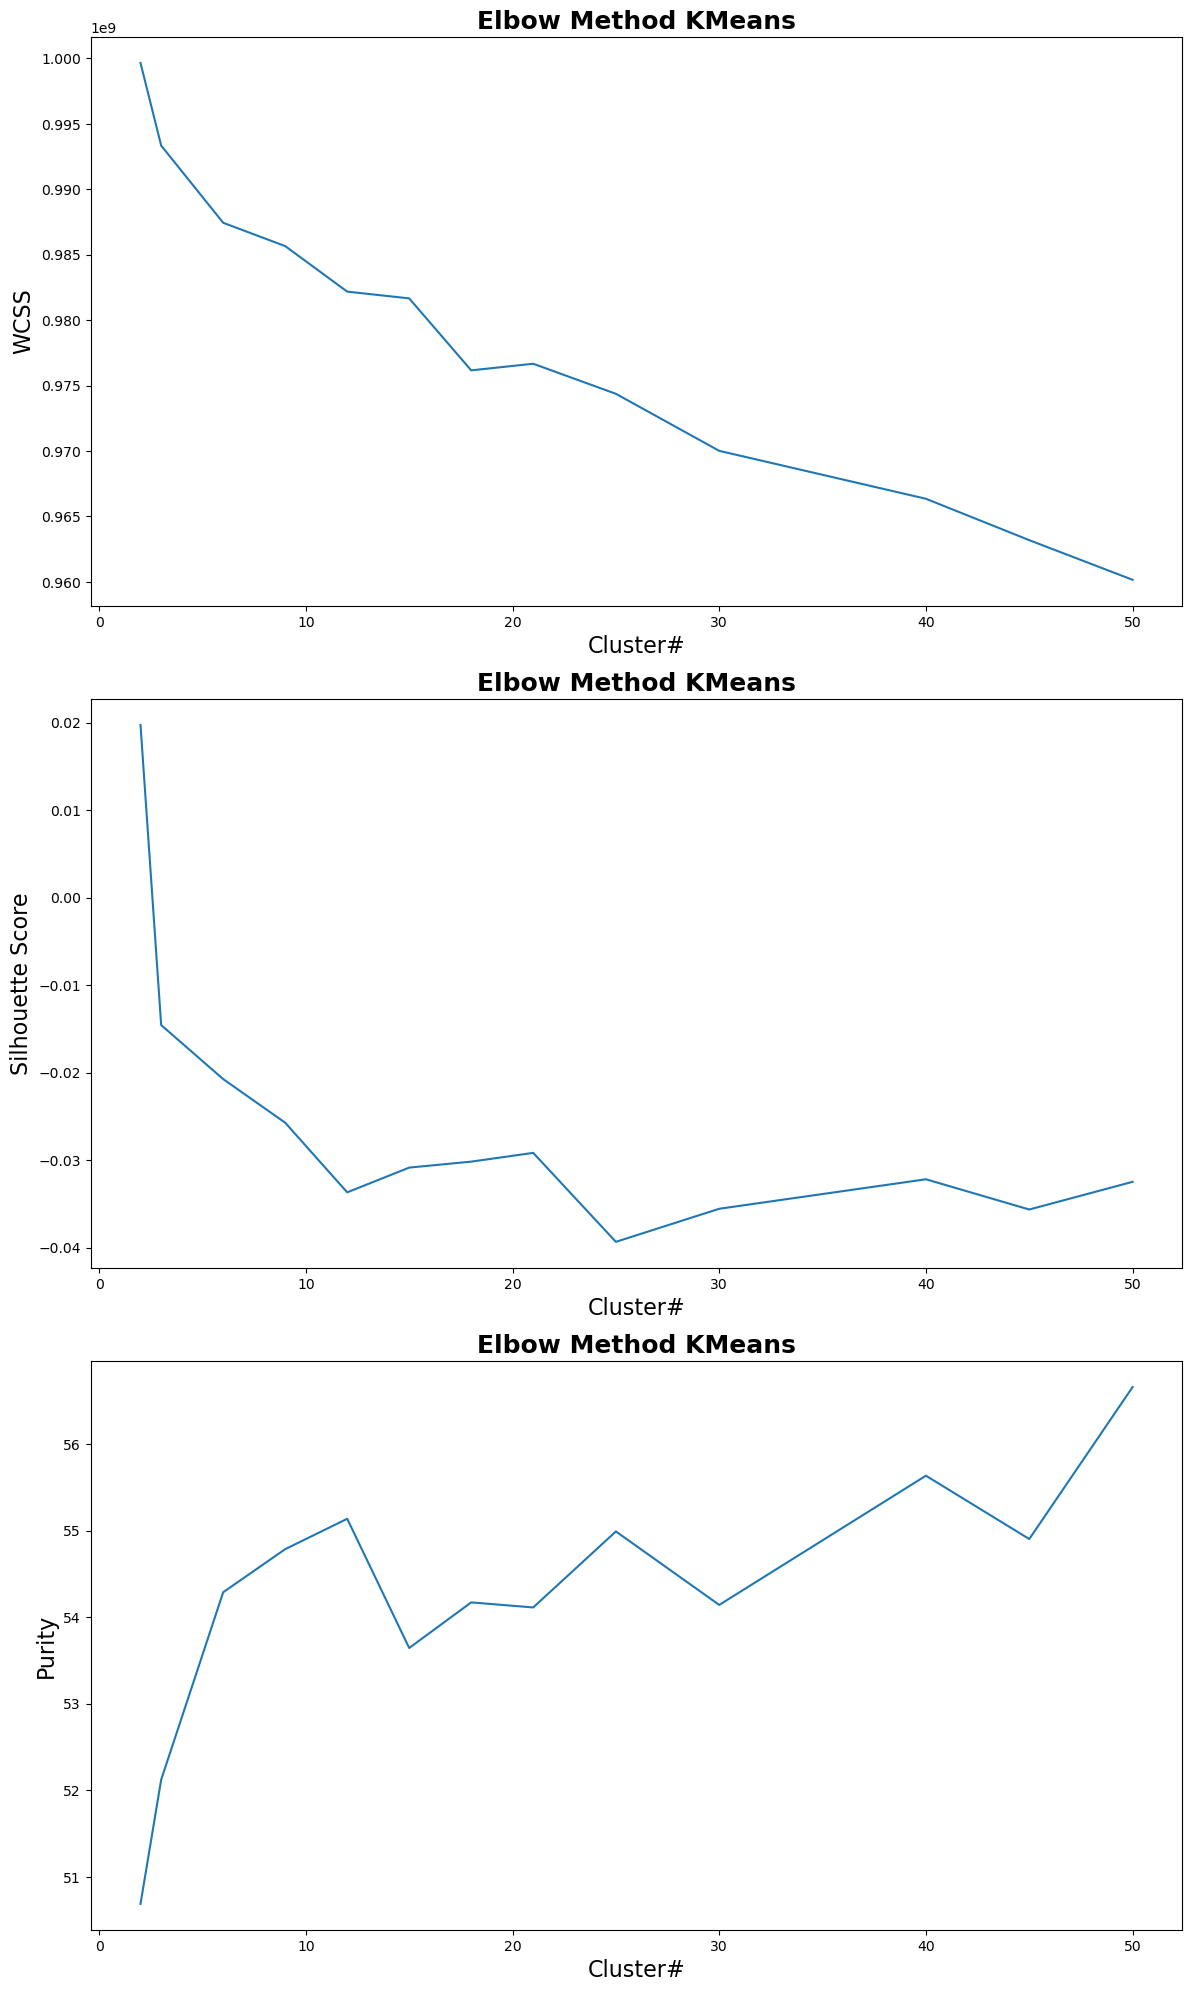

In [21]:
plt.figure(figsize=(12,20))
plt.subplot(3,1,1)
g = sns.lineplot(y='WCSS', x='n_clusters', data=scores_df)
plt.title('Elbow Method KMeans', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('WCSS', fontsize=plotAXLableSize)
plt.xlabel('Cluster#', fontsize=plotAXLableSize)

plt.subplot(3,1,2)
g = sns.lineplot(y='silhouette_score', x='n_clusters', data=scores_df)
plt.title('Elbow Method KMeans', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('Silhouette Score', fontsize=plotAXLableSize)
plt.xlabel('Cluster#', fontsize=plotAXLableSize)


plt.subplot(3,1,3)
g = sns.lineplot(y='purity', x='n_clusters', data=scores_df)
plt.title('Elbow Method KMeans', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('Purity', fontsize=plotAXLableSize)
plt.xlabel('Cluster#', fontsize=plotAXLableSize)


plt.tight_layout(pad=1.0)
plt.savefig(figPath + '1-KMeans_lbp_feature.png', dpi=pltDPI)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:53<00:00,  9.45s/it]


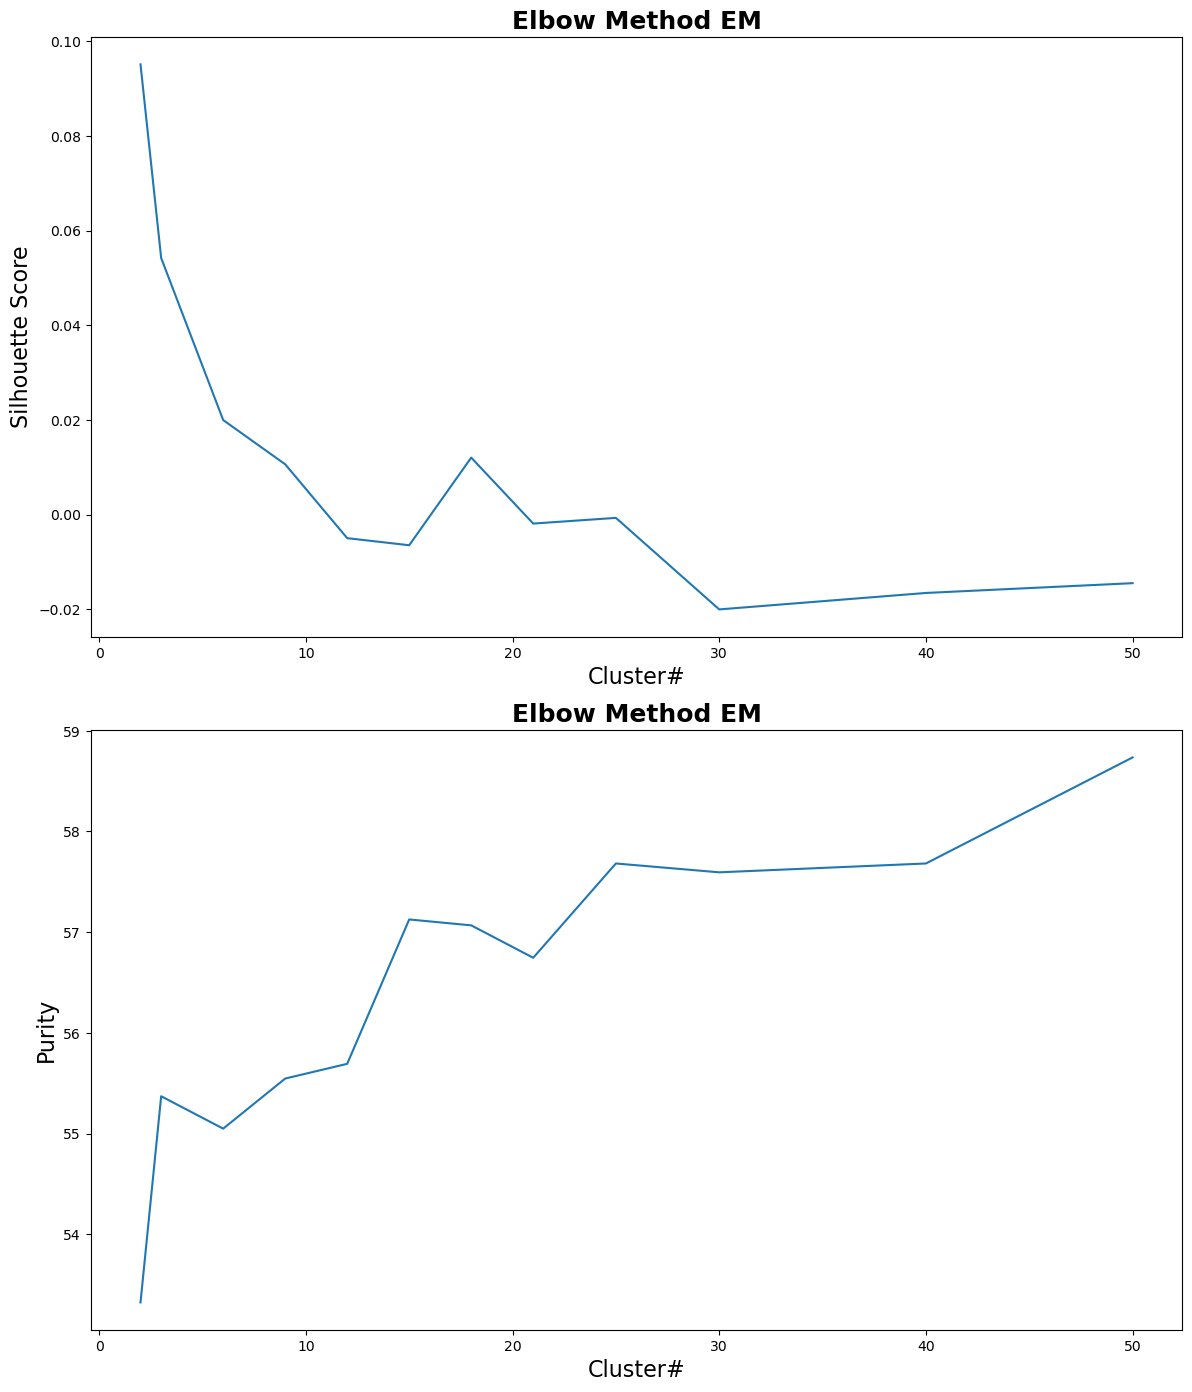

In [61]:
data = []
range_n_clusters = [2,3,6,9,12,15,18,21,25,30,40,50]
for n_clusters in tqdm(range_n_clusters):
    gmm = GaussianMixture(n_components=n_clusters)  # Specify the number of clusters
    gmm.fit(X)
    cluster_labels = gmm.predict(X)
    purity = calculate_purity(true_label=y, cluster_label=cluster_labels)
    silhouette_avg = silhouette_score(X, cluster_labels)
    data.append([n_clusters, silhouette_avg, purity])
    
scores_df = pd.DataFrame(data=data, columns=['n_clusters', 'silhouette_score', 'purity']) # within-cluster sum of squares

plt.figure(figsize=(12,14))
plt.subplot(2,1,1)
g = sns.lineplot(y='silhouette_score', x='n_clusters', data=scores_df)
plt.title('Elbow Method EM', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('Silhouette Score', fontsize=plotAXLableSize)
plt.xlabel('Cluster#', fontsize=plotAXLableSize)

plt.subplot(2,1,2)
g = sns.lineplot(y='purity', x='n_clusters', data=scores_df)
plt.title('Elbow Method EM', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('Purity', fontsize=plotAXLableSize)
plt.xlabel('Cluster#', fontsize=plotAXLableSize)


plt.tight_layout(pad=1.0)
plt.savefig(figPath + '2-EM_lbp_feature.png', dpi=pltDPI)

In [62]:
scores_df

,n_clusters,silhouette_score,purity
0,2,0.095100,53.321627
1,3,0.054188,55.370208
2,6,0.019973,55.048288
3,9,0.010627,55.545800
4,12,-0.004972,55.692128
5,15,-0.006470,57.126134
6,18,0.012041,57.067603
7,21,-0.001891,56.745683
8,25,-0.000689,57.682177
9,30,-0.020023,57.594381


In [44]:
eps_array = [2, 4, 6, 8, 10, 50]
min_sampel_array = [2, 3, 4, 5, 6, 7, 8]
data = []
for eps in tqdm(eps_array):
    for min_sampel in min_sampel_array:
        clustering = DBSCAN(eps=eps, min_samples=min_sampel).fit(X)
        n_clusters = len(np.unique(clustering.labels_))
        if n_clusters <= 1:
            continue
        cluster_labels = clustering.labels_
        silhouette_avg = silhouette_score(X, cluster_labels)
        purity = calculate_purity(true_label=y, cluster_label=clustering.labels_)
        data.append([eps, min_sampel, n_clusters, silhouette_avg, purity])
        
scores_df = pd.DataFrame(data=data, columns=['eps', 'min_sampel', 'n_clusters', 'silhouette_avg', 'purity'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:45<00:00,  7.52s/it]


In [45]:
scores_df

,eps,min_sampel,n_clusters,silhouette_avg,purity
0,2,2,60,-0.067069,53.906936
1,2,3,14,-0.066226,51.273047
2,2,4,4,-0.022256,50.395083
3,4,2,60,-0.067069,53.906936
4,4,3,14,-0.066226,51.273047
5,4,4,4,-0.022256,50.395083
6,6,2,60,-0.067069,53.906936
7,6,3,14,-0.066226,51.273047
8,6,4,4,-0.022256,50.395083
9,8,2,60,-0.067069,53.906936


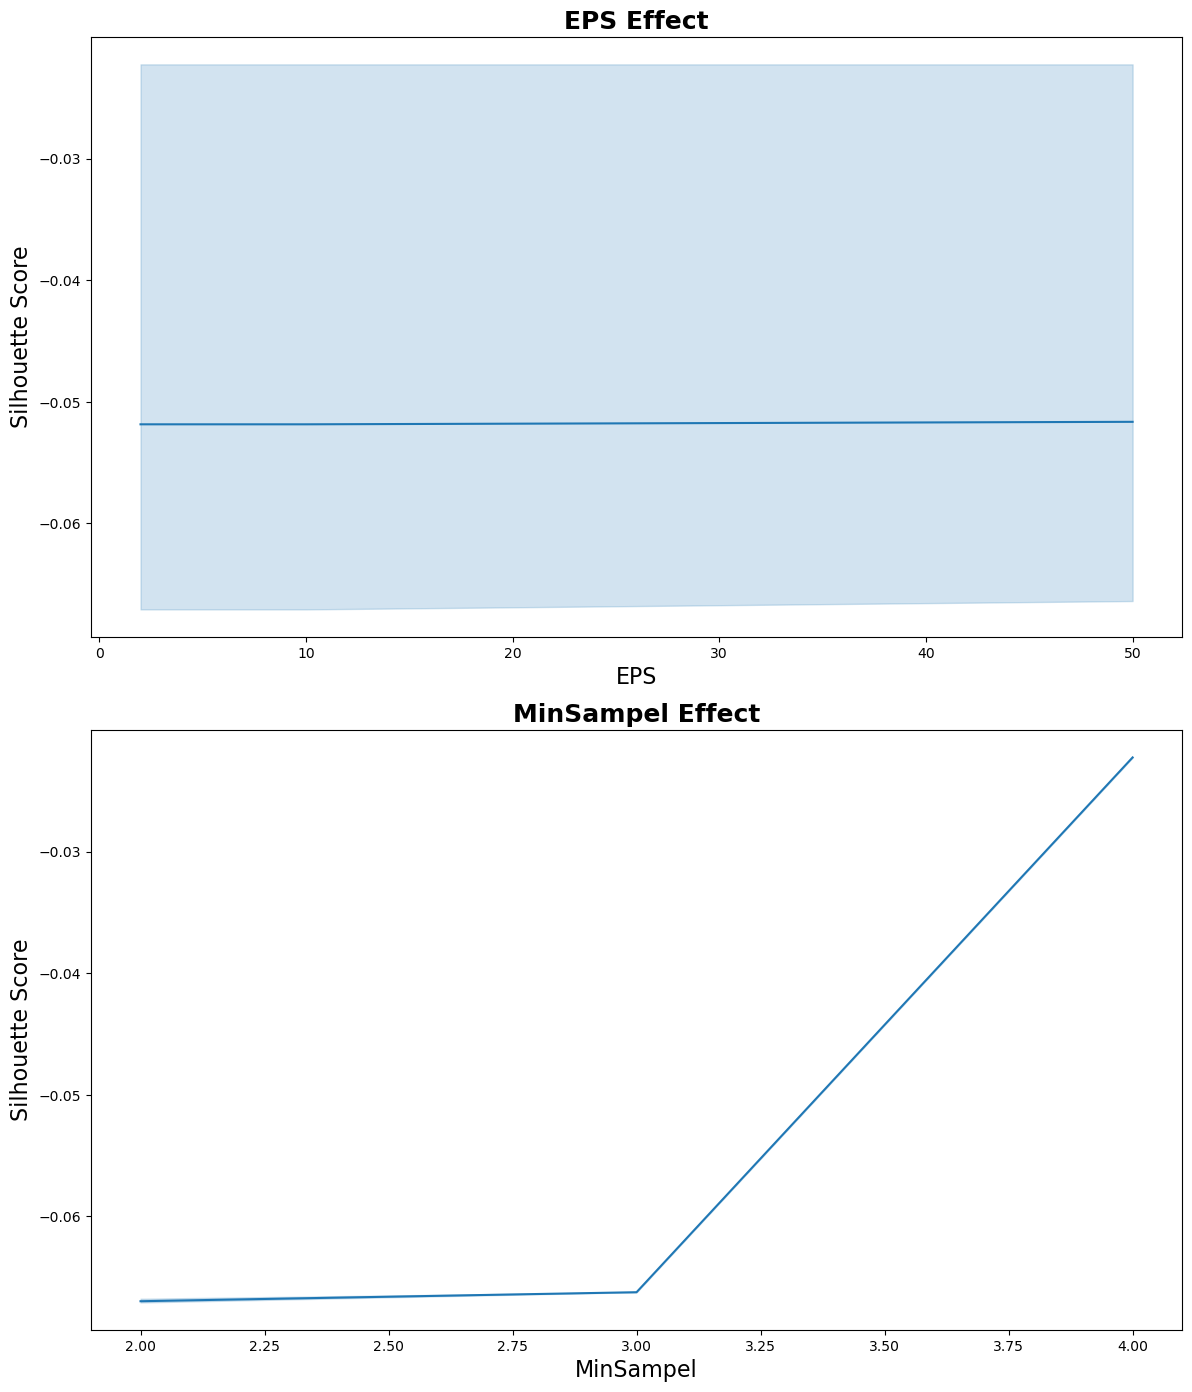

In [46]:
plt.figure(figsize=(12,14))
plt.subplot(2,1,1)
g = sns.lineplot(y='silhouette_avg', x='eps', data=scores_df)
plt.title('EPS Effect', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('Silhouette Score', fontsize=plotAXLableSize)
plt.xlabel('EPS', fontsize=plotAXLableSize)

plt.subplot(2,1,2)
g = sns.lineplot(y='silhouette_avg', x='min_sampel', data=scores_df)
plt.title('MinSampel Effect', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('Silhouette Score', fontsize=plotAXLableSize)
plt.xlabel('MinSampel', fontsize=plotAXLableSize)
# plt.axvline(x=70, color='r')

plt.tight_layout(pad=1.0)
plt.savefig(figPath + '3-DBScan_lbp_feature.png', dpi=pltDPI)

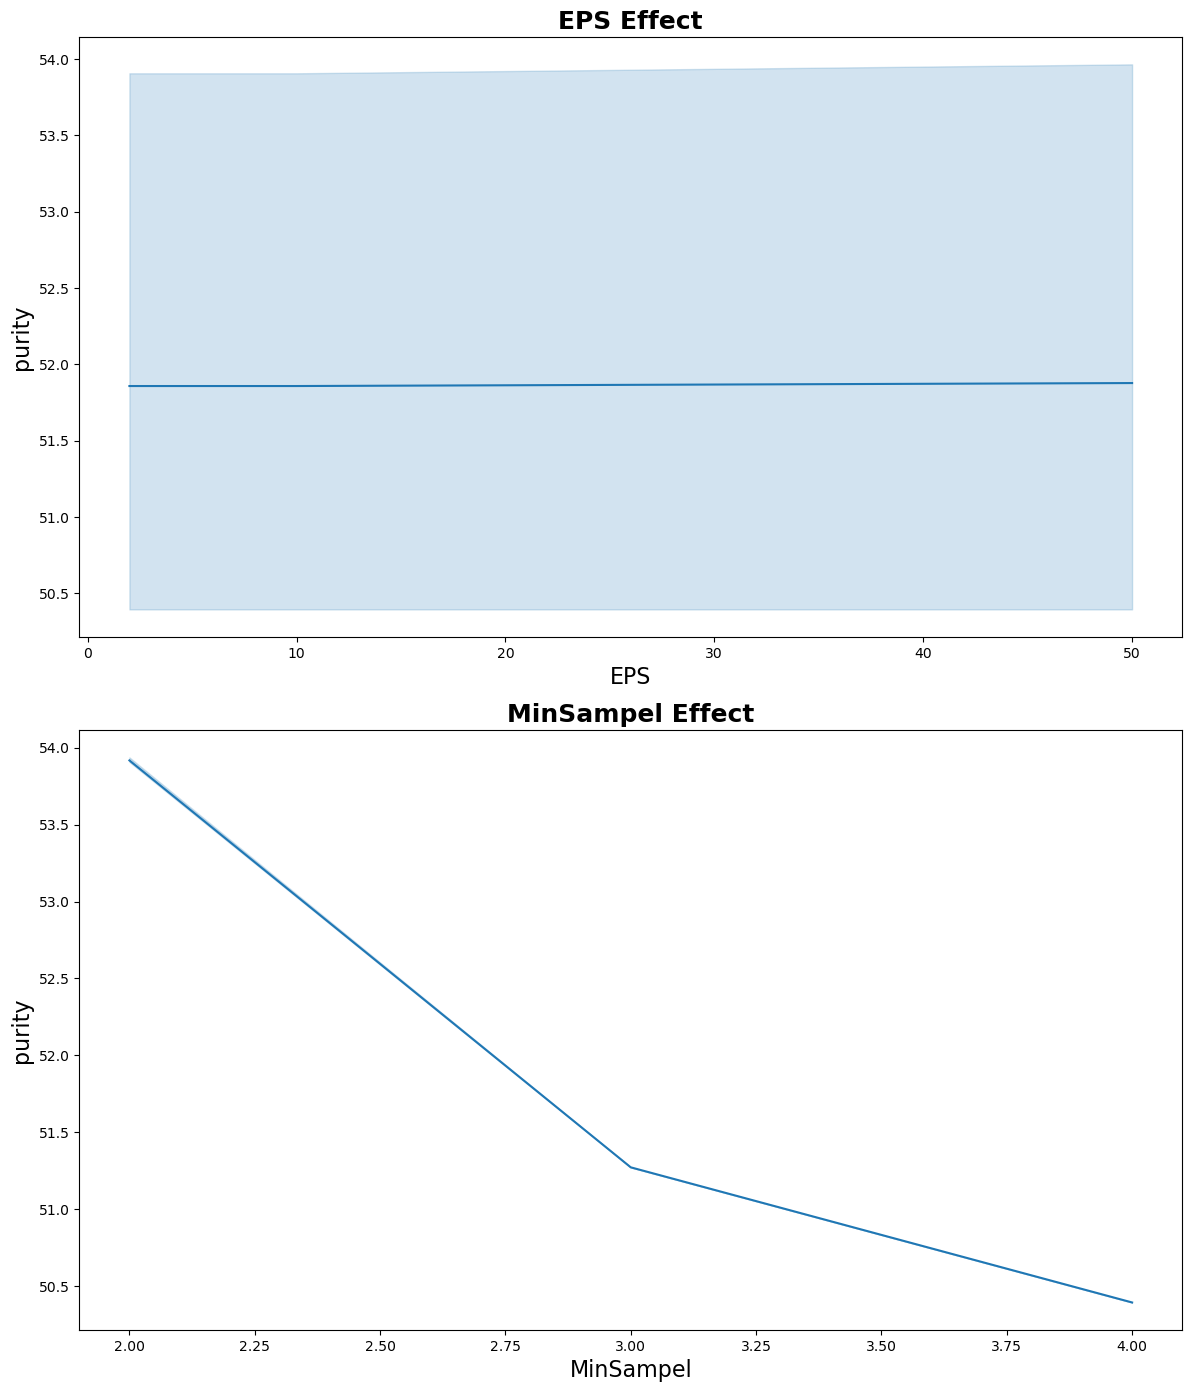

In [47]:
plt.figure(figsize=(12,14))
plt.subplot(2,1,1)
g = sns.lineplot(y='purity', x='eps', data=scores_df)
plt.title('EPS Effect', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('purity', fontsize=plotAXLableSize)
plt.xlabel('EPS', fontsize=plotAXLableSize)
plt.subplot(2,1,2)
g = sns.lineplot(y='purity', x='min_sampel', data=scores_df)
plt.title('MinSampel Effect', fontsize=plotTitleSize, fontweight='bold')
plt.ylabel('purity', fontsize=plotAXLableSize)
plt.xlabel('MinSampel', fontsize=plotAXLableSize)

plt.tight_layout(pad=1.0)
plt.savefig(figPath + '4-DBScan_lbp_feature.png', dpi=pltDPI)